# Introduction

This example demonstrates using a network pretrained on ImageNet for classification. The model used was converted from the VGG_CNN_S model (http://arxiv.org/abs/1405.3531) in [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). 

For details of the conversion process, see the example notebook "Using a Caffe Pretrained Network - CIFAR10".

### License
The model is licensed for non-commercial use only

### Download the model (393 MB)

In [1]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl
import sys
sys.path.append('../../coco/PythonAPI')
import os
from pycocotools.coco import COCO
import numpy as np
from numpy import reshape
import skimage.io as io
import matplotlib.pyplot as plt
#modulename = importlib.machinery.SourceFileLoader('modulename','/Path/To/module.py').load_module()


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import json
with open('../../coco/annotations/instances_train2014.json') as data_file:
    data = json.load(data_file)

In [3]:
dataDir='../../coco'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
cocoTrain=COCO(annFile)
dataType='val2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
cocoVal=COCO(annFile)

loading annotations into memory...
Done (t=16.22s)
creating index...
index created!
loading annotations into memory...
Done (t=8.48s)
creating index...
index created!


In [4]:
cats = cocoTrain.loadCats(cocoTrain.getCatIds())
#print(cats)
validCatIds = [x['id'] for x in cats]
print(validCatIds)
yo = cocoTrain.loadImgs(185652)
#print(yo[0]['id'])
yo2 = cocoTrain.loadAnns(ids=[185652])
#print(yo2[0]['category_id'])
yoyo = cocoTrain.getImgIds()
#print(yo2[0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


In [21]:
def getXandY(coco,minimumCatCount,validCatIds):
    allImgIds = coco.getImgIds()
    singleCatImgIds = []
    allAnnIds = coco.getAnnIds(imgIds=allImgIds);
    myDict = {}
    counter = 0
    for i in range(len(allImgIds)):
        #tempAnns = coco.loadAnns(ids=allAnnIds[i])
        tempAnns = coco.loadAnns(coco.getAnnIds(imgIds=allImgIds[i]))
        tempImg = coco.loadImgs(allImgIds[i])
        allCategoriesList = []
        for x in tempAnns:
            allCategoriesList.append(x['category_id'])
        allCategoriesList = set(allCategoriesList)
        if len(allCategoriesList)==1:
            counter += 1
            myDict[allImgIds[i]] = [tempAnns[0]['category_id'], tempImg[0]['file_name']]
            singleCatImgIds.append(allImgIds[i])
    allSingleCategories = [x[0] for x in list(myDict.values())]
    categoryCounts = {x:allSingleCategories.count(x) for x in validCatIds}
    plentifulCategories = [x for x in validCatIds if categoryCounts[x]>=minimumCatCount]
    plentifulCategoryCounts = {x:categoryCounts[x] for x in plentifulCategories}
    plentifulImageIds = [x for x in list(myDict.keys()) if myDict[x][0] in plentifulCategories]
    plentifulDict = {k:myDict[k] for k in plentifulImageIds}
    return [plentifulDict, plentifulCategories, plentifulCategoryCounts]

trainList = getXandY(cocoTrain, 100, validCatIds)
trainDict = trainList[0]
#The validation set should only contain categories which are also in the training set. 
#Therefore we pass the category ids from the training set as validCatIds
valList = getXandY(cocoVal, 50, trainList[1])
valDict = valList[0]

In [31]:
print "Number of images in training set:",len(trainList[0]) 
print "Number of images in validation set:",len(valList[0])
#Ensure that validation does not have less categories than training set
print "Training and val. set have the same categories:", trainList[1]==valList[1] 


Number of images in training set: 15449
Number of images in validation set: 7709
Training and val. set have the same categories: True


In [4]:
#Define a function which can read images, resize them to 480x640 and save the resized image in place of the original
from PIL import Image
def resizer(directory,width,height):
    i = 0
    for image in os.listdir(directory):
        if i%1000 == 0:
            print(i)
        # Open the image file.
        img = Image.open(os.path.join(directory, image))
        # Resize it.
        img = img.resize((width, height), Image.BILINEAR)
        # Save it back to disk.
        img.save(os.path.join(directory,image))
        i += 1
    print('Batch processing complete.')
#resizer('../../coco/train2014',224,224)
#resizer('../../coco/val2014',224,224)
#resizer('../../coco/test2014',224,224)


In [7]:
dataDir = "../../coco"
dataType = "../../coco"
allFiles = os.listdir('../../coco/train2014')
height = 224
width = 224
N = 1
x_train = []
x_train = np.empty([N,3,height,width])
i = 0
j = 0
for filename in allFiles:
    i += 1
    if i>N-1:
        break
    if i%100 == 0:
        print(i)
    #print(i)
    I = io.imread('%s/%s/%s'%(dataDir,'train2014',filename))
    if I.shape == (height, width, 3):
        x_train[j,:,:,:] = np.transpose(I,(2,0,1))
        j += 1
    else:
        print("yo",i)
    #x_train[i,:,:,:] = np.transpose(io.imread('%s/%s/%s'%(dataDir,'train2014',filename)),(2,0,1))

In [8]:
x_train.shape

(1, 3, 224, 224)

In [9]:
#print(x_train.shape)
#plt.figure()
#plt.imshow(I[0,:,:])
#plt.show()

# Setup

In [10]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 4007)


### Define the network

In [13]:
net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1'] = ConvLayer(net['input'], num_filters=96, filter_size=7, stride=2, flip_filters=False)
net['norm1'] = NormLayer(net['conv1'], alpha=0.0001) # caffe has alpha = alpha * pool_size
net['pool1'] = PoolLayer(net['norm1'], pool_size=3, stride=3, ignore_border=False)
net['conv2'] = ConvLayer(net['pool1'], num_filters=256, filter_size=5, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, ignore_border=False)
net['conv3'] = ConvLayer(net['pool2'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['conv4'] = ConvLayer(net['conv3'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['conv5'] = ConvLayer(net['conv4'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['pool5'] = PoolLayer(net['conv5'], pool_size=3, stride=3, ignore_border=False)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
#net['fc8'] = DenseLayer(net['drop7'], num_units=1000, nonlinearity=lasagne.nonlinearities.softmax)
net['fc8Modified'] = DenseLayer(net['drop7'], num_units=80, nonlinearity=lasagne.nonlinearities.softmax)
output_layer = net['fc8Modified']
#output_layer = net['pool5']

In [14]:
import pickle

model = pickle.load(open('vgg_cnn_s.pkl'))
CLASSES = model['synset words']
MEAN_IMAGE = model['mean image']
for i in range(10,len(model['values'])-2):
    print(i, model['values'][i].shape)
    model['values'][i].fill(0)
    
# If we do not cast to float32 we get this error: 
#TypeError: ('CudaNdarrayType(float32, vector), with dtype float32, 
#cannot store a value of dtype float64 without risking loss of precision.
#If you do not mind, please cast your data to float32.'
model['values'][14] = np.zeros((4096,80)).astype(np.float32)
model['values'][15] = np.zeros((80,)).astype(np.float32)
#lasagne.layers.set_all_param_values(output_layer, model['values'])
#lasagne.layers.set_all_param_values(output_layer, model["values"][0:10])
print('')
for i in range(len(model['values'])):
    print(i, model['values'][i].shape)
lasagne.layers.set_all_param_values(output_layer, model['values'])
#lasagne.layers.set_all_param_values(output_layer, model["values"][0:10]

(10, (18432, 4096))
(11, (4096,))
(12, (4096, 4096))
(13, (4096,))

(0, (96, 3, 7, 7))
(1, (96,))
(2, (256, 96, 5, 5))
(3, (256,))
(4, (512, 256, 3, 3))
(5, (512,))
(6, (512, 512, 3, 3))
(7, (512,))
(8, (512, 512, 3, 3))
(9, (512,))
(10, (18432, 4096))
(11, (4096,))
(12, (4096, 4096))
(13, (4096,))
(14, (4096, 80))
(15, (80,))


In [15]:
import theano
import theano.tensor as T
#Setting up the graph in theano
sym_x = T.tensor4('sym_x') # a symbolic variable, this is now a 4-D tensor.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Retrieve network output
train_out = lasagne.layers.get_output(output_layer, sym_x, deterministic=False)
eval_out = lasagne.layers.get_output(output_layer, sym_x, deterministic=True)

# Retrieve list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(output_layer, trainable=True)

#Define our cost function
cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)

# Set the update function for parameters 
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

#f_val takes x and t and passes them to the cost function.
f_val = theano.function([sym_x, sym_t],
                         [cost],on_unused_input='warn')

f_eval = theano.function([sym_x],
                     eval_out, on_unused_input='warn')

f_train = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

In [18]:
#Test the forward pass
x = np.random.normal(0,1, (2, 3,224,224)).astype('float32') #dummy data

model = lasagne.layers.get_output(output_layer, sym_x)
out = model.eval({sym_x:x}) #this could also include mask etc if used
print("l_out", out.shape)
print(out)

('l_out', (2, 80))
[[ 0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125]
 [ 0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125  0.0125
   0.0125  0.0125  0.0125 

In [ ]:
#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 100
batch_size_val = 5
num_epochs = 5
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
loss_val = []
try:
    for epoch in range(num_epochs):
        
        #Own code
        cur_loss_d = 0
        for i in range(num_batches_valid):
            idx_d = range(i*batch_size_val, (i+1)*batch_size_val)
            x_batch_d = x_valid[idx_d]
            target_batch_d = targets_valid[idx_d]    
            batch_loss_d = f_val(x_batch_d,target_batch_d)
            cur_loss_d += batch_loss_d[0]
        loss_val += [cur_loss_d/batch_size_val]
        
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]    
            batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
            cur_loss += batch_loss[0]
        loss += [cur_loss/batch_size]
        

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
net_out = f_eval(x_test)    
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

plt.figure()
plt.plot(epoch,loss,'r',epoch,loss_val,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.ylim([0,0.2])

### Load the model parameters and metadata

In [23]:
MEAN_IMAGE[0,:,:]

array([[ 115.67246246,  115.50032043,  115.6844101 , ...,  115.60919952,
         115.76387787,  115.6491394 ],
       [ 115.55817413,  115.39704895,  115.54529572, ...,  115.53969574,
         115.63127899,  115.51085663],
       [ 115.4719162 ,  115.30929565,  115.45373535, ...,  115.45130157,
         115.56884766,  115.45667267],
       ..., 
       [ 101.91355896,  101.71341705,  101.80757904, ...,  101.98206329,
         102.12422943,  102.01231384],
       [ 101.98280334,  101.76641083,  101.87499237, ...,  102.02365875,
         102.16687012,  102.04932404],
       [ 102.04597473,  101.80661011,  101.98251343, ...,  102.0905838 ,
         102.29478455,  102.20030975]], dtype=float32)

In [14]:
model["values"][0].shape

(96, 3, 7, 7)

# Trying it out

### Get some test images
We'll download the ILSVRC2012 validation URLs and pick a few at random

In [15]:
import urllib

index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(25)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

In [16]:
image_urls = ["http://farm1.staticflickr.com/15/22703851_729cd2cd04.jpg"]

### Helper to fetch and preprocess images

In [17]:
import io
import skimage.transform

def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

### Process test images and print top 5 predicted labels

(1, 3, 224, 224)


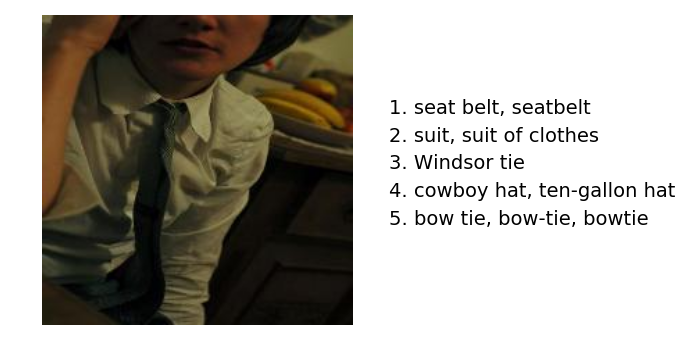

In [18]:
import skimage.io as io
for url in image_urls:
    try:
        #rawim, im = prep_image(url)
        im = io.imread('%s/%s/%s'%(dataDir,'train2014',allFiles[16]))
        rawim = np.copy(im).astype('uint8')
        im = np.transpose(im,(2,0,1))
        im = np.reshape(im,(1,3,224,224))
        print(im.shape)
        im = im - MEAN_IMAGE
        prob = np.array(lasagne.layers.get_output(output_layer, im, deterministic=True).eval())
        top5 = np.argsort(prob[0])[-1:-6:-1]

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')
        for n, label in enumerate(top5):
            plt.text(250, 70 + n * 20, '{}. {}'.format(n+1, CLASSES[label]), fontsize=14)
    except IOError:
        print('bad url: ' + url)

In [24]:
print(CLASSES)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 